# Uncertainties determination of gravitational lens
### Strong Lensing meets Deep Ensemble

Analyses of strong lensing images still a non-trivial task for cosmologists and astronomers. Despite they are powerful probes, the current techniques available to identify and analyse lens images are limited and tipically computationally expensive. Thus, construct or propos new ways to perform these tasks still a crucial step for cosmologist and astronomers (see [arXiv:1911.06341](https://arxiv.org/abs/1911.06341) and references therein for a detailed discussion). 

Here, we attempt to use a deep learning method to analyse gravitational lens images. Specifically, we use the deep ensemble method to regress physical parameters and its corresponding uncertainties (see [arXiv:1612.01474](https://arxiv.org/abs/1612.01474)). In this particular case and for sake of demonstration, we aim to regress only the Einstein radius having as input the strong lensing image.

## Libraries

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl
import tensorflow.keras.models as tfkm
import tensorflow.keras.initializers as tfki
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB1

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as py
import cv2
import h5py
from astropy.io import fits
from astropy.nddata import Cutout2D
import scipy.misc
from keras.preprocessing.image import array_to_img
import os
import random
import time

## Global variables

In [3]:
img_dim = [75,75,3] # image shape
data_f = 'GroundBasedTraining/classifications_final.csv' # data_f

### Aesthetic definitions

In [4]:
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = (12,8)

## Import Lensing Data Frame

We import the Data Frame generated after data inspection (see *visualize_and_data_inspection* notebook for further information). As mentioned before, we aim to obtain the Einstein Radius for each lens, however the Einstein Radius, $\theta_E$, is not present on the data frame but rather the Einstein Area,  $A_E$. We use  $A_E$ to obtain the Einstein Radius through the relation $\theta_E = \sqrt{A_E/\pi}$. Note that the Einstein Area is given on square radians leading then to a Einstein Radiuson in radians. For sake of convenience, we transfrom $\theta_E$ to arcsec using: $\theta_E \rightarrow (3600 × 180)/\pi * \theta_E$.

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma,folder,Einstein_radius
0,100000,1,6.039480e-10,804,3714.6800,Data.1,2.859894
1,100002,1,7.180970e-11,51,57.6093,Data.0,0.986147
2,100003,1,1.764110e-11,347,18815.4000,Data.0,0.488780
3,100005,1,1.221390e-10,275,386.1880,Data.1,1.286108
4,100007,1,9.350820e-10,668,2188.0100,Data.1,3.558566


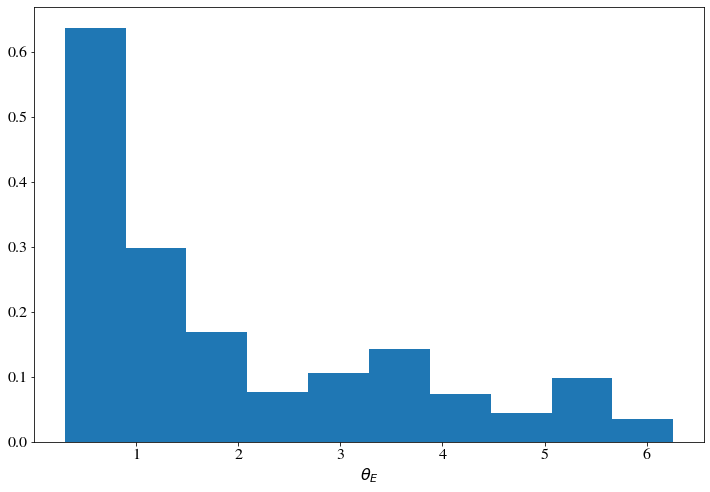

In [5]:
lens_df = pd.read_csv(data_f,delimiter=',', header=0)

lens_dict = {}
for il, lens in enumerate(lens_df['ID']):
    lens_dict[str(lens)] = lens_df['folder'][il]

lens_df['Einstein_radius'] = np.sqrt(lens_df['Einstein_area']/np.pi)*3600*180/np.pi
plt.hist(lens_df['Einstein_radius'],density=True)
plt.xlabel(r'$\theta_E$')

lens_df.head(5)

The above histogram shows that gravitational lens with lower $\theta_E$ are more likely to be found in our data set. This means, our dataset is rather a imbalanced dataset. In this first approach we do not tackle this problem.

## Deep ensemble to predict uncertainties

Before to present and discuss our model, we review and briefly summarize how deep ensembles can be used to determinate uncertainties (we use as main reference [arXiv:1612.01474](https://arxiv.org/abs/1612.01474)).

Ensembles of NNs, or deep ensembles for short, have been successfully used to boost predictive performance of tipical problems. Its intrinsic variability not only helps to  reduce the variance on results but also provide a better and more robust prediction as compare with a single neural network. The features made the deep ensemble approach a suitable alternative for regression problem, specially to determinate uncertainties. 

Deep emsemble was for the fisrt time apply to the uncertainties problem on [arXiv:1612.01474](https://arxiv.org/abs/1612.01474). Authors showed that deep emsemble are suitable for regression problem, specially if the aim is both determinate a parameter, $\hat{\theta}$, and its uncertainty, $\sigma$. To summarize up, deep emseble can be used to uncertainties problems applying the following recipe:
1. Define a proper LOSS for the regression problem
2. Train  networks (independently) in parallel using (or not) randomic batchs
3. Weight networks results

Here, we use the Negative Log-Likelihood (NLL) as our LOSS estimator. NLL takes into account both the mean value of the parameter to be estimate, $\hat{\theta}$, and its variance, $\sigma$, to score the LOSS by:

$ -\log p_\omega(y_n|x_n) = 0.5 * \left( \log \sigma_\omega(x)^2 + (y-\hat{\theta}(x)_\omega)^2/\sigma(x)_\omega^2\right) \,,$

where $x$ is the input data, $y$ is the true value of $\theta$ (usually dubbed as label) and the subcript $\omega$ denotes a implicit dependency on network parameters (weights and bias). One can note that the regressed parameters, $\hat{\theta}$ and $\sigma$, depedent also on the input data. In others words, our model is not only composed by the architecture of the neural network but also the data used on training. This means, the same architecture trained with the same data in the same way constitutes the same model. Since that deep ensemble aims to improve the results and reduce the variance using differents model we should try not use the same data for all NNs.That is why when we train a network from the emsemble at each epoch we choose a randomic subset of the full data set, in order to ensure that each network represents a different model, although due to randomness the whole data set will pass through the training process. Also, in order to reduce any possible correlations between the netwroks all the parameters of the network are initiate randomly (here we do an exception on this that will be discussed later).

### Architecture

For sake of simplicity, we will consider a ensemble with three neural networks (NN), each of them will be conformed by a `EfficientNetB1` in the begining followed by five dense layers of 256, 64, 32, 1 and 1 units, respectively. Note that these NN are not sequentials since the output of the dense layer of 32 units is splitted to two differents dense layers of 1 unit whose activation function are linear . It is worthwhile to highlight that all dense layers initialize with random weights and bias as deep ensemble approach requieres, however we use the pre-trained parameters of the `EfficientNetB1` in order to reduce the number of epochs. Neverthless, a more robust approximation should avoid use the same parameters on differents NN this in orden to avoid possible correlations. 

We define the function `get_network`, that will give in charge to create the aforementioned architecture. It uses as inputs the name of NN and the dimensions of the input image. `tfki.GlorotNormal()` ensures that dense layers' parameters are initialized randomly.

In [6]:
def get_network(network_name,input_dim):
    init = tfki.GlorotNormal()
    effB1 = EfficientNetB1(include_top=False, input_shape=(input_dim[0], input_dim[1], input_dim[-1]),
                           weights='imagenet') # weights='imagenet'
    flat_1 = tfkl.Flatten()(effB1.output)
    dense_1 = tfkl.Dense(256, activation='relu', kernel_initializer=init, bias_initializer=init)(flat_1)
    dense_2 = tfkl.Dense(64, activation='relu', kernel_initializer=init, bias_initializer=init)(dense_1)
    dense_3 = tfkl.Dense(32, activation='relu', kernel_initializer=init, bias_initializer=init)(dense_2)
    out_mean = tfkl.Dense(1, activation='linear', kernel_initializer=init, bias_initializer=init)(dense_3)
    out_raw_var = tfkl.Dense(1, activation='linear', kernel_initializer=init, bias_initializer=init)(dense_3)
    out_var = tf.keras.backend.log(1.0 + tf.exp(out_raw_var)) + 5e-3
    model = tf.keras.Model(name=network_name,inputs=[effB1.inputs], outputs=[out_mean,out_var])
    return model

Note that this is rather a simple architecture, works or not works?

### Training Strategy

As mentioned before, our training strategy include the use of a random sub sample of the whole dataset at each epoch. The size of such sub sample will be set by the variable `rand_size`. The `rand_sample` function can be used to select a random sub sample of data using only a data frame. It uses as inputs the name of the data frame, the name of the column to contains the ID of the lens, the y label, the input dimension and the size of the sub sample.  On the other hand, the function `track_sub_sample` just simply map positions of a cetains elements (partial_tab)  on a bigger array (full_tab). Then, such positions are project over a third array (apply_tab).

In [7]:
rand_size = 512

def track_sub_sample(full_tab,partial_tab,apply_tab):
    index_partial = [np.where(full_tab==pt)[0][0] for pt in partial_tab]
    return apply_tab[index_partial]

def rand_sample(data_frame,x_name,y_name,bands,input_dim,rand_size,info=False):
    x_batch = np.zeros((rand_size,input_dim[0],input_dim[1],3))
    lens_to_train = random.sample(list(data_frame[x_name]),k=rand_size)
    for il, len_it in enumerate(lens_to_train):
        fol = lens_dict[str(len_it)]
        for ib, bnd in enumerate(bands): # not include U
            ib += 1
            idximg = 'imageSDSS_'
            root = 'GroundBasedTraining/'+fol+'/Public/Band%i/'%ib
            len_file = root+idximg+bnd+'-'+str(len_it)+'.fits'
            if info == True:
                fits.info(len_file)
            len_data = fits.getdata(len_file, ext=0)
            len_data= np.float32(len_data)
            sC = len_data.shape[0] / 2
            len_data = Cutout2D(len_data, (sC, sC), (input_dim[0], input_dim[1]))
            len_data = np.array(len_data.data)
            len_data = cv2.normalize(len_data, None, 0, 255, cv2.NORM_MINMAX)
            len_data = np.float32(len_data)
            x_batch[il,:,:,ib-1] = len_data
    y_batch = track_sub_sample(data_frame[x_name],lens_to_train,data_frame[y_name])
    y_batch = np.array(y_batch).reshape(len(y_batch),1)
    return x_batch, y_batch

Here follows an example of how `track_sub_sample` works

In [8]:
ae = np.array([0,1,2,3,4,5,6,7,8,9])
ae_part = np.array([8,0,3,1,9,7])
be = np.array(['a','b','c','d','e','f','g','h','i','j'])
track_sub_sample(ae,ae_part,be)

array(['i', 'a', 'd', 'b', 'j', 'h'], dtype='<U1')

In addition, we define the `data_to_batch` function which separate data on batchs.

In [9]:
def data_to_batch(x_true,y_true,size):
    data = tf.data.Dataset.from_tensor_slices({
    'x': np.array(x_true).astype(np.float32),
    'y': np.array(y_true).astype(np.float32)})
    data = data.shuffle(20).batch(size)
    return data

Finally, we define the Gaussian Negative Log-Likelihood `gaussian_nll` and the function `grad` that compute gradients through the NN 

In [10]:
def gaussian_nll(model, x_true, y_true):
    mean_values,var_values = model(x_true)
    y_diff = tf.math.subtract(y_true, mean_values)
    nll_mean = 0.5*tf.divide(tf.square(y_diff),var_values)
    nll_var = 0.5*tf.math.log(var_values)  
    nll = tf.reduce_mean(nll_mean + nll_var)
    return nll

def grad(model, x_true, y_true):
    with tf.GradientTape() as tape:
        loss = gaussian_nll(model, x_true, y_true)
    grads = tape.gradient(loss, model.trainable_variables)
    return loss, grads

### Debugging

Before to process to train our NNs, we display and test some of the function before mentioned in order to identify possible bugs. We start defining a NN called `test_simp`, then we select a random sample (size 32) from data and evaluate the two functions `gaussian_nll` and `grad`.

In [11]:
# Defining NN
test_simp = get_network('test_simp',img_dim)

# Selecting a random sample of size 16. Note that Einstein_radius is our label.
x_b, y_b = rand_sample(lens_df,'ID','Einstein_radius',['R','I','G'],img_dim,32)
x_b.shape, y_b.shape

# Evaluating the LOSS and the gradients.
print(gaussian_nll(test_simp,x_b,y_b))
print(grad(test_simp,x_b,y_b))

tf.Tensor(2.91926, shape=(), dtype=float32)
(<tf.Tensor: shape=(), dtype=float32, numpy=2.91926>, [<tf.Tensor: shape=(3, 3, 3, 32), dtype=float32, numpy=
array([[[[ 4.67453152e-02,  2.56196484e-02,  7.27597438e-03,
          -2.06440501e-03,  9.04395361e-04, -2.12877616e-03,
           3.29395677e-11,  7.66312107e-02,  4.10318188e-02,
           2.03710375e-03,  4.01193160e-04,  3.09709972e-03,
          -1.05008222e-01,  5.08754626e-02,  1.30621821e-01,
           1.59737691e-01,  2.79908270e-01, -5.55999205e-02,
           3.54017201e-03,  8.96693450e-07,  2.69586034e-02,
           4.94489726e-03, -1.73263736e-02, -6.32151216e-02,
           7.25551173e-02,  3.05910595e-04, -2.45784782e-03,
          -1.38339261e-02,  5.09560667e-02, -8.91819745e-02,
          -8.68508369e-02,  2.02950388e-02],
         [ 6.10957434e-03,  6.41068816e-02,  1.14760716e-02,
           4.31767926e-02,  4.07553790e-03, -4.40448476e-03,
           2.58661391e-11,  5.51045388e-02,  6.29033521e-02,
        

We also compare the histogram of the Einstein Radius of the full data set compared with the random selection y_b.

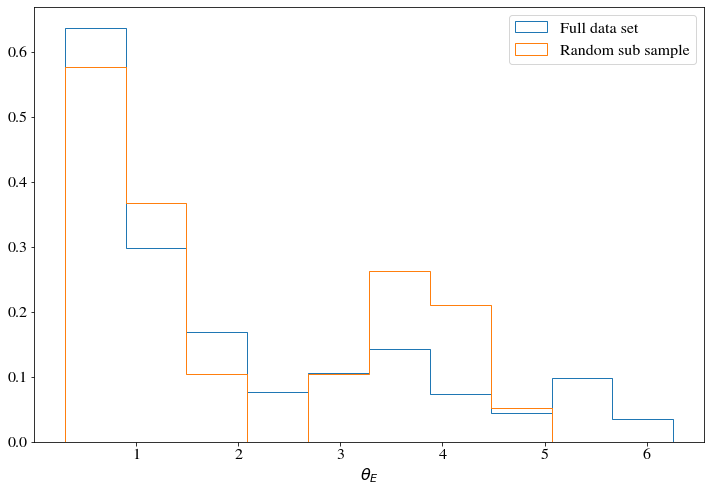

In [12]:
plt.hist(lens_df['Einstein_radius'],bins=np.histogram(lens_df['Einstein_radius'])[1],density=True,histtype='step',
         label='Full data set')
plt.hist(y_b,bins=np.histogram(lens_df['Einstein_radius'])[1],density=True,label='Random sub sample',histtype='step')
plt.xlabel(r'$\theta_E$')
plt.legend(loc=0)

## Training process

### Training variables

Although training variables are often set to its default values, they play an important role on the training process and depending on the model a fine-tunning could be require. In this case, we have found that the suitable optimizer is the `Adadelta` optimizer since it avoids manual tunning of the learning rate. We have also tried several other optimizers as for example `Adagrad` and `Adam`, however they tend to fail since the learning rate have to be precise ajusted in onder to avoid exploding gradients and/or slow convergence. We set `learning_rate` equal to 0.05, however we have checked that lower values also work.

In [13]:
learning_rate =  0.05
optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate) 

We define the number of epochs, the names of the network and the bands to be used on training.

In [14]:
num_epochs =  80
networks = ['network1', 'network2','network3'] 
bands_to_train = ['R','I','G']
batch_size = 32

Now, we split the lens data frame on a train and test part. 

In [15]:
train_ratio = 0.8
train_len = int(train_ratio*len(lens_df))
train_df = lens_df[:train_len]
test_df = lens_df[train_len:]
test_df = test_df.reset_index(drop=True)

### Training the ensemble

We define the ensemble through the function `get_network` using the NNs names stated in the variable `networks`. All architectures are store in a dictionary `models_dict`.

In [16]:
models_dict = {}

for net in networks:
    models_dict[net] = get_network(net,img_dim)

The training is perfomed using the so-called mini-batch gradient descent approach. We select a random sub sample using `get_network`, then such sub sample is splitted on batchs through the function `data_to_batch`. At each batch we compute the loss, gradients and optimize the NN's parameters using functions `grad` and `optimizer.apply_gradients`. Note that at each batch we also compute the loss of the test sample. 

In [17]:
num_print = 1

loss_train = np.zeros([num_epochs,len(networks)])
loss_test = np.zeros([num_epochs,len(networks)])

num_batchs = int(len(train_df)/batch_size)

# Epochs loop
for epoch in range(num_epochs):
    start_time = time.time()    
    
    # Nets loop
    for inet, net in enumerate(networks):
        
        model = models_dict[net]
        
        # Training loop
        loss_batch_train = 0
        loss_batch_test = 0
        
        x, y = rand_sample(train_df,'ID','Einstein_radius',bands_to_train,img_dim,rand_size)
        data_train = data_to_batch(x,y,batch_size)
        
        x_t, y_t = rand_sample(test_df,'ID','Einstein_radius',bands_to_train,img_dim,len(test_df))
        data_test = data_to_batch(x_t,y_t,batch_size)
        
        count_t = 0
        count = 0
        for data_t in data_test:
            count_t += 1
            x_t, y_t = data_t['x'], data_t['y']
            loss_t = gaussian_nll(model,x_t,y_t)
            loss_batch_test += loss_t
        
        for data in data_train:
            count += 1
            x, y = data['x'], data['y']
            # Optimize the model
            loss, grads = grad(model, x, y)
            grads = [tf.clip_by_norm(g, 1.) for g in grads]
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            loss_batch_train += loss
            
        loss_train[epoch,inet] = loss_batch_train/count
        loss_test[epoch,inet] = loss_batch_test/count_t
    
        models_dict[net] = model
        
        del model
                
    if epoch % num_print == 0 and epoch != 0:
        print(('-------------------------') + ' Iteration: ' + str(epoch) + ' -------------------------')
        print('Average Loss(NLL): ' + str(loss_train[epoch,:]))
        print('Average Loss(NLL): ' + str(loss_test[epoch,:]))
        print('Time: ' + str(time.time() - start_time) + ' seconds')

------------------------- Iteration: 1 -------------------------
Average Loss(NLL): [0.6880669  0.58921105 0.67993718]
Average Loss(NLL): [1.3870759  0.67486608 0.95002407]
Time: 105.68980407714844 seconds
------------------------- Iteration: 2 -------------------------
Average Loss(NLL): [0.33824164 0.41936854 0.56626922]
Average Loss(NLL): [0.38955233 0.45075855 0.52817202]
Time: 101.47382354736328 seconds
------------------------- Iteration: 3 -------------------------
Average Loss(NLL): [0.24952455 0.3003521  0.46075433]
Average Loss(NLL): [0.19578795 0.34501833 0.70242703]
Time: 101.30627727508545 seconds
------------------------- Iteration: 4 -------------------------
Average Loss(NLL): [0.38458171 0.17337827 0.47967705]
Average Loss(NLL): [0.58335775 0.21560925 0.54000336]
Time: 101.4336416721344 seconds
------------------------- Iteration: 5 -------------------------
Average Loss(NLL): [0.43384004 0.17238279 0.35403475]
Average Loss(NLL): [0.2804186  0.12265579 0.70810813]
Time

------------------------- Iteration: 40 -------------------------
Average Loss(NLL): [-0.52391249 -0.55759978 -0.26704654]
Average Loss(NLL): [-0.38439989 -0.49283734 -0.21612653]
Time: 101.56465268135071 seconds
------------------------- Iteration: 41 -------------------------
Average Loss(NLL): [-0.61839336 -0.55259335 -0.45852438]
Average Loss(NLL): [-0.28158727 -0.16487746 -0.31775925]
Time: 101.50502586364746 seconds
------------------------- Iteration: 42 -------------------------
Average Loss(NLL): [-0.52597642 -0.45586893 -0.40697372]
Average Loss(NLL): [-0.33732602 -0.46147302 -0.22017731]
Time: 101.81397461891174 seconds
------------------------- Iteration: 43 -------------------------
Average Loss(NLL): [-0.44495666 -0.50367093 -0.43111983]
Average Loss(NLL): [-0.47883824 -0.50874364 -0.24653244]
Time: 101.39513802528381 seconds
------------------------- Iteration: 44 -------------------------
Average Loss(NLL): [-0.60502291 -0.60234797 -0.30920029]
Average Loss(NLL): [-0.33

------------------------- Iteration: 79 -------------------------
Average Loss(NLL): [-0.91206199 -0.73467839 -0.65831041]
Average Loss(NLL): [-0.4913429   0.75645047 -0.539253  ]
Time: 101.347891330719 seconds


## Results

Here, we show our results. The figure below shows the loss vs. epoch for each of the NNs and the ensemble. Despite that all NNs are in agreement, it is easily to note that the LOSS have not converged yet and more training is needed. In addition, one can also point out that there is small overfitting starting at epoch ~ 50. 

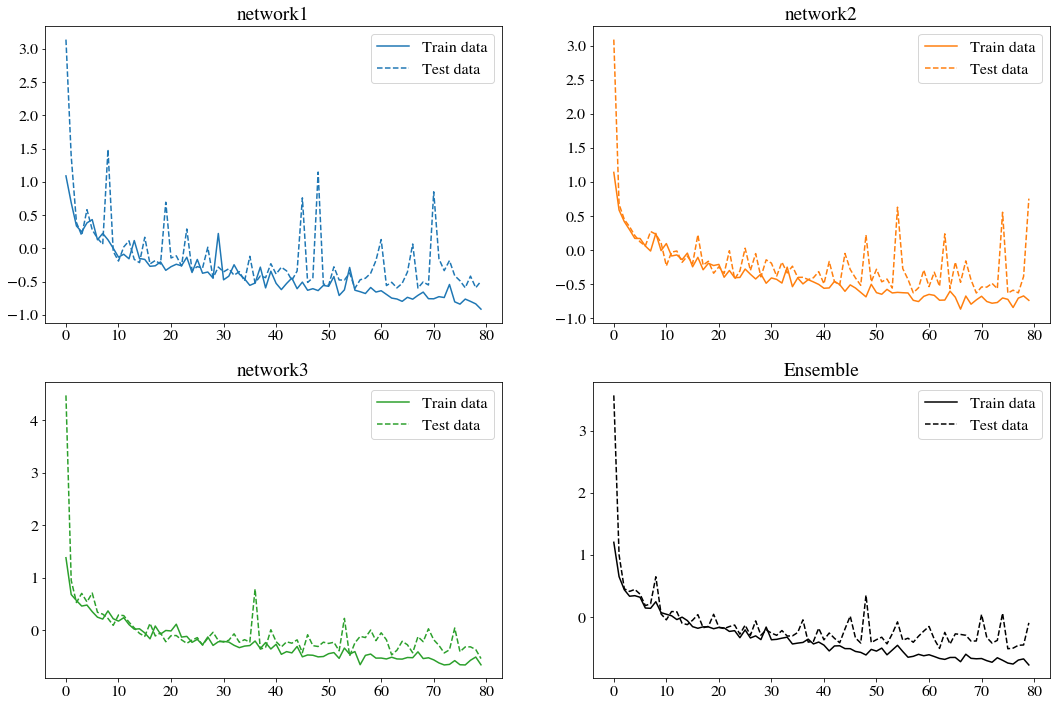

In [81]:
plt.rcParams["figure.figsize"] = (18,12)
fig, axs = plt.subplots(2,2)

for i in range(len(networks)):
    axs[i//2,i%2].plot(loss_train[:,i],color='C'+str(i),label='Train data')
    axs[i//2,i%2].plot(loss_test[:,i],'--',color='C'+str(i),label='Test data')
    axs[i//2,i%2].set_title(networks[i])
    axs[i//2,i%2].legend(loc=0)    

axs[1,-1].plot(np.mean(loss_train,axis=1),color='k',label='Train data')
axs[1,-1].plot(np.mean(loss_test,axis=1),'--',color='k',label='Test data')
axs[1,-1].set_title('Ensemble')

plt.legend(loc=0)

We also define a function that helps us to manage our results. `ensemble_net` receives the name of the model, a empty dictionary and the input data to make the prediction. This functions will store the predictions given both by the NNs and the emsemble in the inpute empty dictionary. 

In [19]:
def ensemble_net(models,mydict,x):
    if type(mydict) != dict:
        raise Exception('Make sure mydict is a dictionary')
    
    mu_tab = []
    var_tab = [] 
    for key in models_dict.keys():
        model = models_dict[key]
        mu, var = model(x)
        mydict[key+'_mu'] = mu
        mydict[key+'_var'] = var
        mydict[key+'_sig'] = tf.sqrt(var)
        mydict[key+'_lower_1sig'] = mu - tf.sqrt(var)
        mydict[key+'_upper_1sig'] = mu + tf.sqrt(var)
        mu_tab.append(mu)
        var_tab.append(var)
    
    mu_tab = np.array(mu_tab)
    var_tab = np.array(var_tab)
    mu_tab_mean = mu_tab.mean(axis=0)
    var_tab_mean = np.mean(var_tab + mu_tab**2,axis=0) - mu_tab_mean**2
    
    mydict['ensemble_mu'] = mu_tab_mean
    mydict['ensemble_var'] = var_tab_mean
    mydict['ensemble_sig'] = np.sqrt(var_tab_mean)
    mydict['ensemble_lower_1sig'] = mu_tab_mean - np.sqrt(var_tab_mean)
    mydict['ensemble_upper_1sig'] = mu_tab_mean + np.sqrt(var_tab_mean)
    
    return

To test our model we select randomly select 32 images from testa data set. Then, `ensemble_net` is used to make predictions. The results are stored in the dictionary `results_dict.`

In [56]:
x_t, y_t = rand_sample(test_df,'ID','Einstein_radius',bands_to_train,img_dim,32)
results_dict = {}
ensemble_net(models_dict,results_dict,x_t)

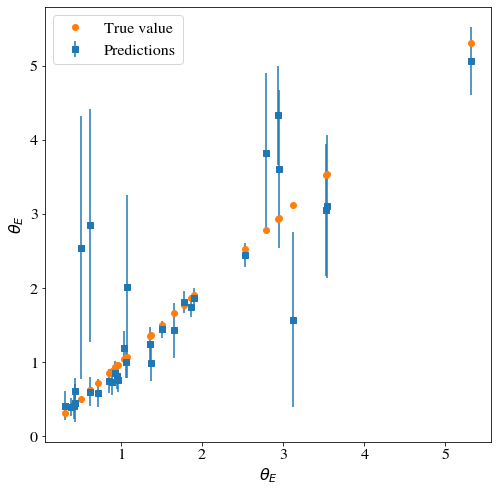

In [65]:
yn = np.ndarray.flatten(y_t)
mun = np.ndarray.flatten(np.array(results_dict['ensemble_mu']))
sign = np.ndarray.flatten(np.array(results_dict['ensemble_sig']))

plt.rcParams["figure.figsize"] = (8,8)
plt.errorbar(yn[yn.argsort()],mun[yn.argsort()],marker='s',
             yerr=sign[yn.argsort()],label='Predictions',ls='')
plt.plot(yn[yn.argsort()],yn[yn.argsort()],'o',label='True value')
plt.xlabel(r'$\theta_E$')
plt.ylabel(r'$\theta_E$')
plt.legend(loc=0)

The previous figure shows the predictions from 32 lens images as compared with the true values of the Einstein Radius. Despite in several cases the predictions and the trua value are in agreement, we can easily note that several of them fail for more than a standard deviation $\sigma$.

This failed point on predition could be generated by several things: few epochs to train, size of the images used, the simply architecture or others. We argue that the dominant effect is the few epochs to train. One can easily note from the figure with the loss that NNs have not converged yet.

This even more clear if we use the whole test data set (see figure below). Most of the regressed $\theta_E$ values for the mean deviate from the true line. We could improve our results including more epochs.

In [73]:
x_t, y_t = rand_sample(test_df,'ID','Einstein_radius',bands_to_train,img_dim,len(test_df))
results_dict = {}
ensemble_net(models_dict,results_dict,x_t)

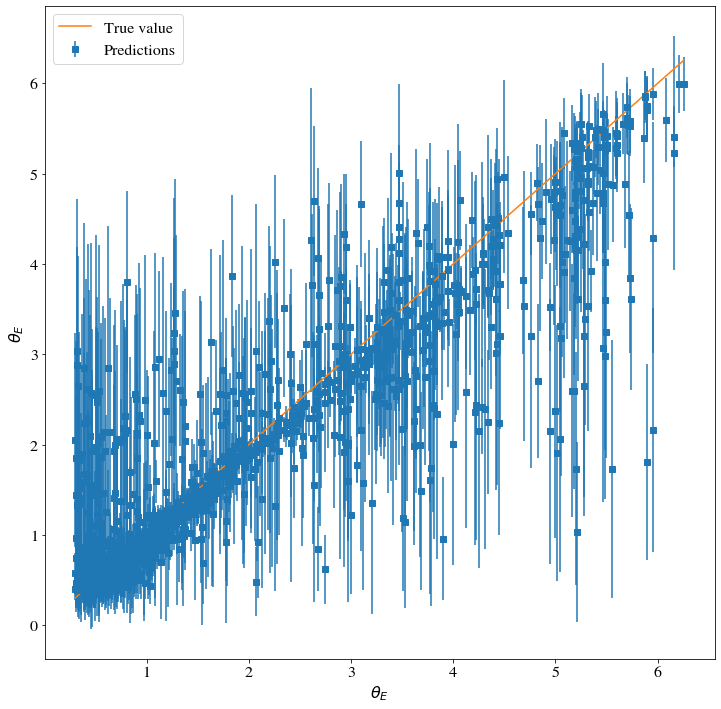

In [77]:
yn = np.ndarray.flatten(y_t)
mun = np.ndarray.flatten(np.array(results_dict['ensemble_mu']))
sign = np.ndarray.flatten(np.array(results_dict['ensemble_sig']))

plt.rcParams["figure.figsize"] = (12,12)
plt.errorbar(yn[yn.argsort()],mun[yn.argsort()],marker='s',
             yerr=sign[yn.argsort()],label='Predictions',ls='')
plt.plot(yn[yn.argsort()],yn[yn.argsort()],'-',label='True value')
plt.xlabel(r'$\theta_E$')
plt.ylabel(r'$\theta_E$')
plt.legend(loc=0)

## Discussion and conclussion

We have used the deep ensemble method to obtain the Einstein Radius from strong lensing images. Our results show that our model is suitable to this regression problem, however more training is needed in order to offers competitive results.

It is important to point that we have tested more simply archictectures, for instance use `EfficientNetB0` instead of `EfficientNetB1`. We have found that more simple architecture will tend to completly fail, they won't reduce the LOSS below ~1 leading then to a very poor prediction. Then, we conclude that architecture given in `get_network` is the minimun arcihtecture required to provide decents results.

Finally, we have to point out that our model is rather a preliminary model in the sense that improvements can be applied. For instance:

1. Use the orignal size of the image, 101x101
2. Improve the architecture, for example including `EfficientNetB2`
3. Increasing the epochs to train
4. Implementing adversarial training